In [4]:
#!pip install librosa spotipy seaborn

In [1]:
# Para visuzalización en notebook
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['font.size'] = 22
from IPython.display import Audio, Markdown, Image

def dmd(x):
    display(Markdown(x))

# Números y Datos
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.interpolate import interp1d

# Análisis de sonido
import librosa
import librosa.display
import spotipy 
from spotipy.oauth2 import SpotifyClientCredentials 

# Machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import adjusted_rand_score

In [2]:
SPOTIFY_CLIENT_ID = 'ab5ca454cd9d4676983488ae254c5a7a'
SPOTIFY_CLIENT_SECRET = '1e21a57a93934a268a80a7cb9de05ea5'

In [3]:
sp = spotipy.Spotify() 
client_credentials_manager = SpotifyClientCredentials(client_id=SPOTIFY_CLIENT_ID, client_secret=SPOTIFY_CLIENT_SECRET) 
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager) 
sp.trace=False

La canción elegida fue The Girl From Ipanema - Stereo Version:

https://open.spotify.com/track/0GrNjx2fUXVbRcjhkYrDAX

In [4]:
track_id = '0GrNjx2fUXVbRcjhkYrDAX'

## sp.audio_features
audio_features contiene features de alto nivel, como cuán bailable o acústico es el audio, su valencia emocional, tempo, etc

In [5]:
# audio_features = pd.read_csv('./data/audio_features.csv', index_col='id')
# pd.DataFrame.head(audio_features)

In [6]:
# af_cancion = audio_features.ix[track_id]

In [7]:
# pd.DataFrame(af_cancion).T

## sp.audio_analysis
Los resultados de audio_analysis contienen descriptores de más bajo nivel divididos por segmentos de audio y más cosas.

In [8]:
location = './data/audio_analysis/timbre/'+track_id+'.csv'
location

'./data/audio_analysis/timbre/0GrNjx2fUXVbRcjhkYrDAX.csv'

In [9]:
aa_timbre_cancion = pd.read_csv(location, index_col='start')
aa_timbre_cancion.head()

#aa_timbre_cancion.columns = aa_timbre_cancion.iloc[0]
#aa_timbre_cancion.drop(aa_timbre_cancion.index[[0]])

,0,1,2,3,4,5,6,7,8,9,10,11
start,,,,,,,,,,,,
0.00000,0.000,171.130,9.469,-28.480,57.491,-50.067,14.833,5.359,-27.228,0.973,-10.640,-7.228
0.34757,4.464,74.428,-104.795,-80.780,5.342,-45.962,12.023,-2.581,-31.311,10.412,-10.622,2.492
0.43488,16.249,-46.234,-38.446,-148.661,30.758,35.284,61.378,-53.675,-32.477,41.150,-42.205,26.711
0.83923,22.830,-134.762,-142.299,-58.783,17.516,-76.978,-20.299,-29.713,-0.999,22.177,-15.800,-8.672
0.93741,25.852,-138.553,-114.744,-34.633,-9.886,-15.605,-23.750,-4.314,27.388,0.118,0.961,4.141


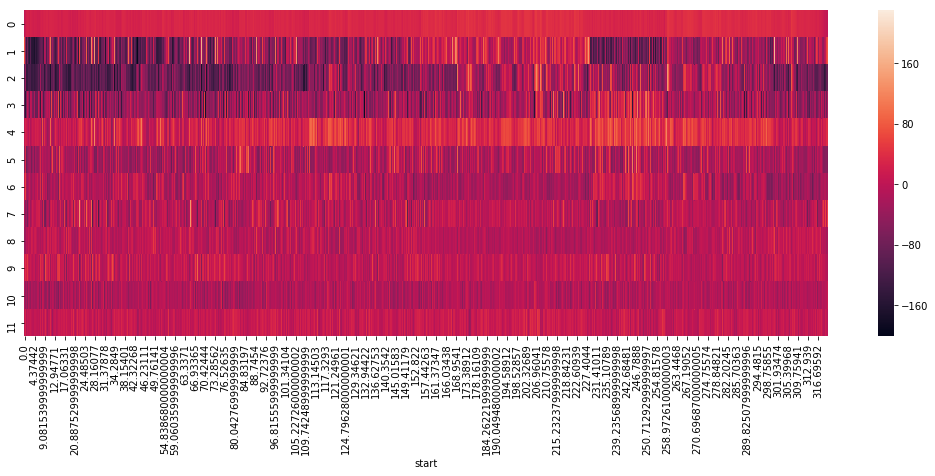

In [10]:
plt.figure(figsize=(18,6))
sns.heatmap(aa_timbre_cancion.T);

Hay que notar que la serie de tiempo que entrega spotify no tiene una frecuencia de muestreo constante. Para arreglar eso podemos interpolar la serie para tener una representación lineal en el tiempo.

In [11]:
first = aa_timbre_cancion.index[0]
last = aa_timbre_cancion.index[-1]
n = len(aa_timbre_cancion)

In [12]:
interp = interp1d(aa_timbre_cancion.index, aa_timbre_cancion.values.T)
timbre_interpolado = interp(np.linspace(0,last,n)).T

Ahora normalizamos los features de timbre y computamos la matriz de distancias con la función pdist seteando una métrica particular.

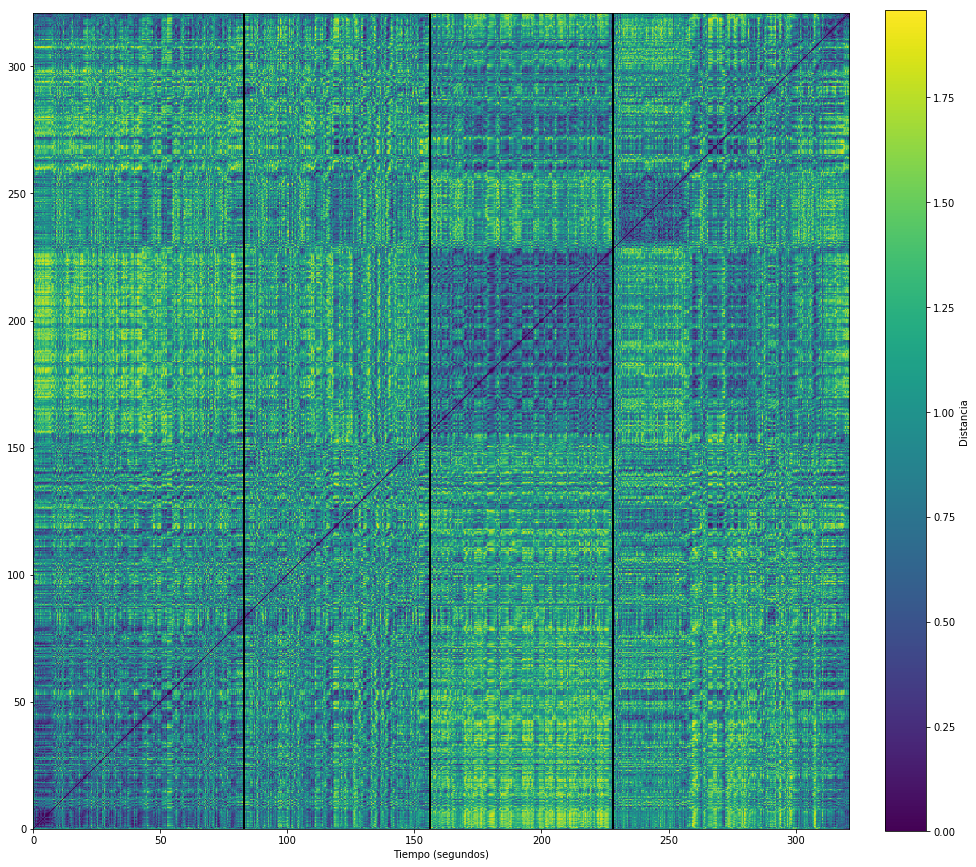

In [13]:
ss = StandardScaler()
timbre_norm = ss.fit_transform(timbre_interpolado)

recurrencia_coseno = squareform(pdist(timbre_norm, metric='cosine'))

plt.figure(figsize=(16,16))
plt.imshow(recurrencia_coseno,aspect='auto',origin='bottom',extent=[0,last,0,last]);
plt.colorbar(label='Distancia',fraction=0.046, pad=0.04)
plt.gca().set_aspect('equal')
plt.xlabel('Tiempo (segundos)')
plt.plot([83,83], [0,321], 'k-', lw=2) # minuto 1.21
plt.plot([156,156], [0,321], 'k-', lw=2) # minuto 2.34
plt.plot([228,228], [0,321], 'k-', lw=2); # minuto 3.47

Una forma de mejorar esta representación es indicando cuantos vecinos (k) se quiere considerar y transformando los valores de distancias o disimilaridades a afinidad. El paquete librosa tiene una función especial para hacer eso.

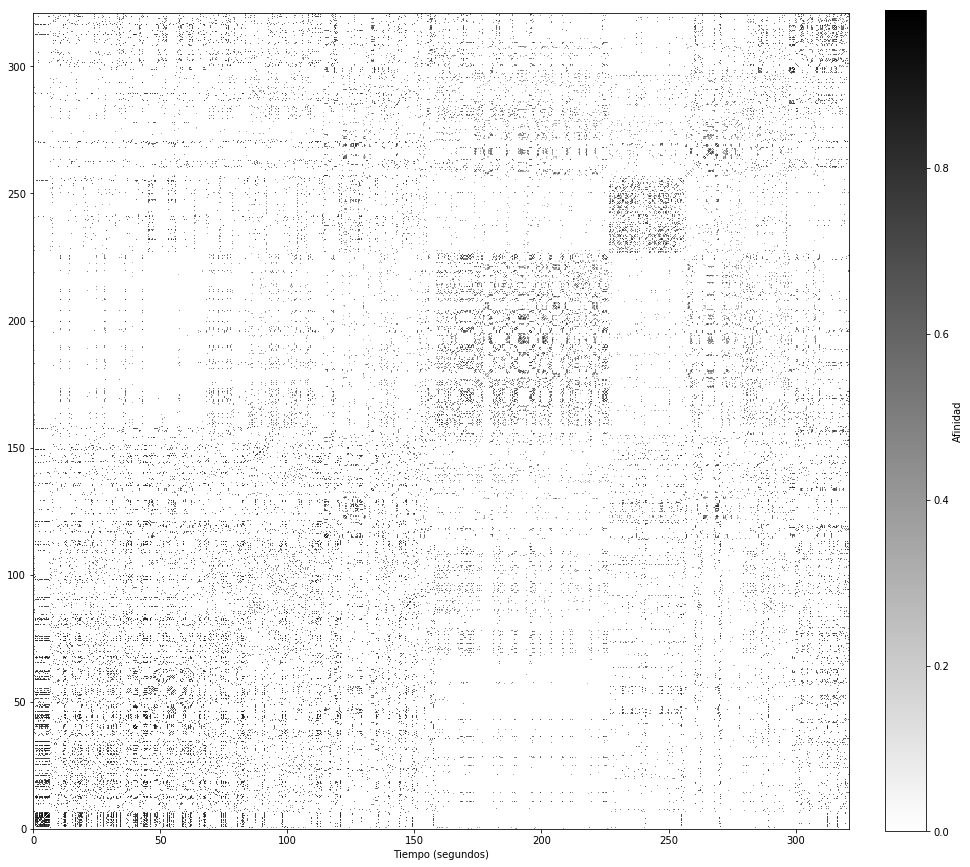

In [14]:
recurrencia_afinidad = librosa.segment.recurrence_matrix(aa_timbre_cancion.T,mode='affinity',sym=True, k = 100,metric='cosine')
plt.figure(figsize=(16,16))
plt.imshow(recurrencia_afinidad,aspect='auto',origin='bottom',extent=[0,last,0,last],cmap=plt.cm.gray_r);
plt.colorbar(label='Afinidad',fraction=0.046, pad=0.04)
plt.gca().set_aspect('equal')
plt.xlabel('Tiempo (segundos)');

Finalmente es posible suavizar esta representación para obtener algo más robusto. Librosa trae una función para hacer eso realzando las diagonales en el sentido temporal

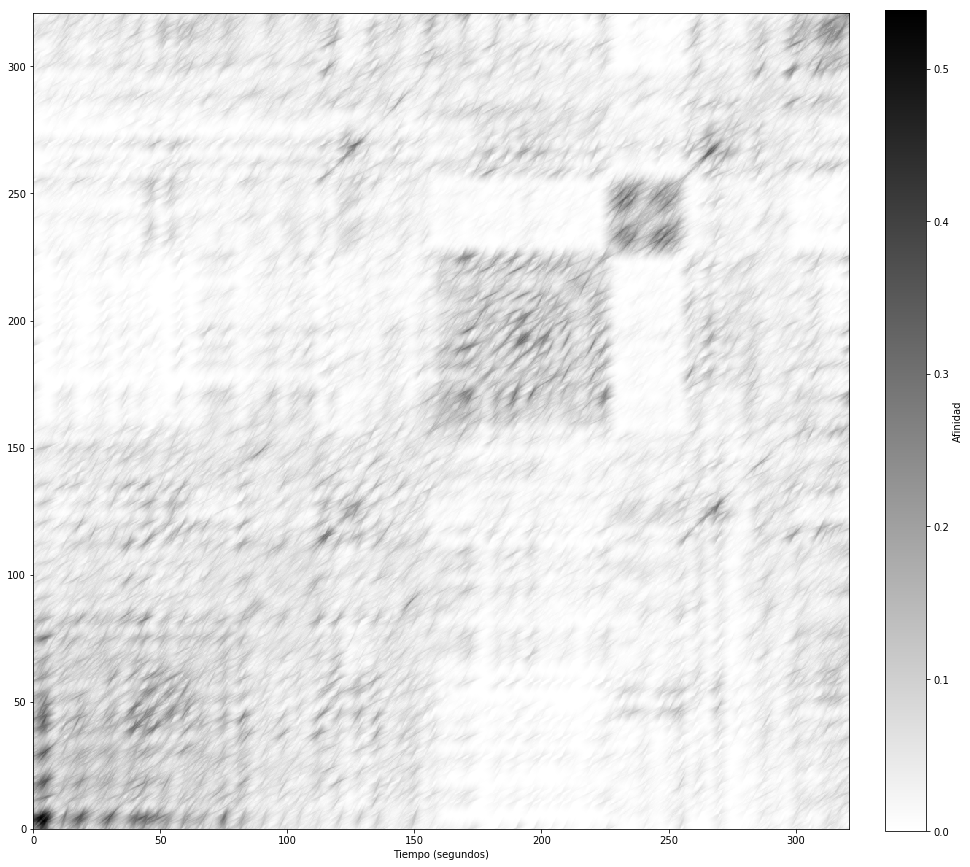

In [15]:
recurrencia_suave = librosa.segment.path_enhance(recurrencia_afinidad, 31, window='hann', n_filters=10)
plt.figure(figsize=(16,16))
plt.imshow(recurrencia_suave,aspect='auto',origin='bottom',extent=[0,last,0,last],cmap=plt.cm.gray_r);
plt.colorbar(label='Afinidad',fraction=0.046, pad=0.04)
plt.gca().set_aspect('equal')
plt.xlabel('Tiempo (segundos)');

Esta matriz suavizada le da de cierta forma coherencia temporal a las distancias. Es decir, si dos instantes de tiempo suenan parecido también sonaran parecido los instantes inmediatamente consecutivos.

Al forzar esto, es posible tratar de hacer algún tipo de clustering para reconocer las secciones que se repiten en el audio (estribillos, estrofas, etc).

Este artículo [1] sugiere realizar clustering sobre los primeros autovectores de la matriz de recurrencia. En cierta medida es similar a cuando se hace PCA y se toman las primeras componentes. Esta técnica se conoce como clustering espectral (los matemáticos suelen hablar de espectro de autovalores, por eso el nombre)

[1] McFee, B., & Ellis, D. (2014). Analyzing Song Structure with Spectral Clustering. In ISMIR (pp. 405-410).

In [16]:
# Cálculo de autovectores de la matriz suavizada
autovalores, autovectores = np.linalg.eig(recurrencia_suave)

Tomamos los primeros 2 autovectores y visualizamos las secciones que encuentra sobre la matriz.

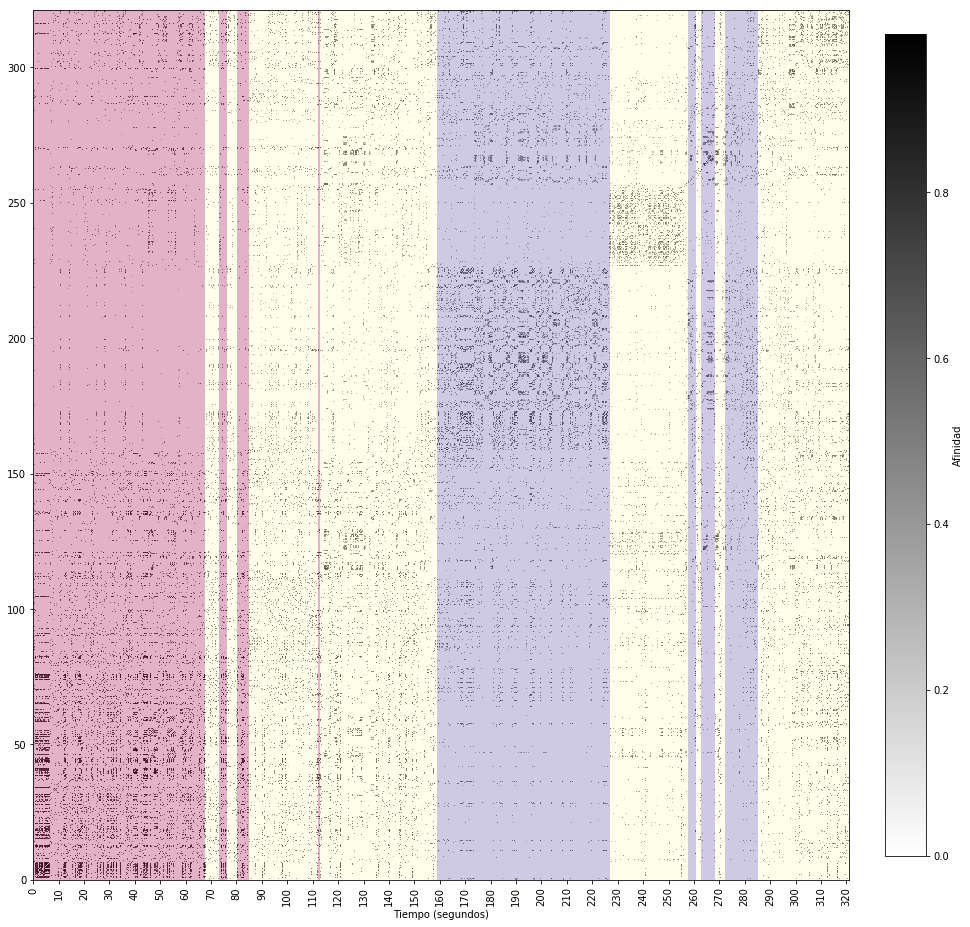

In [17]:
km = KMeans(n_clusters=3)
km.fit(autovectores[:,:2])

plt.figure(figsize=(16,16))
plt.imshow(recurrencia_afinidad, aspect='auto', origin='bottom', extent=[0,last,0,last], cmap=plt.cm.gray_r);
plt.colorbar(label='Afinidad',fraction=0.046, pad=0.04)
plt.gca().set_aspect('equal')
plt.xlabel('Tiempo (segundos)');
plt.xticks(np.arange(0, 322, step= 10),rotation='vertical');

plt.imshow(km.labels_*np.ones(recurrencia_suave.shape),aspect='auto',cmap=plt.cm.Spectral,alpha=0.3, extent=[0,last,0,last]);


#fig.savefig('./plot.png')


Colores:
1) lila: guitarra y voz hombre y parte piano
2) verde:  voz mujer
3) celeste
4) naranja

1) 0.00-0.56:
2) 0.56-0.57:
1) 0.57-1.08:
2) 1.08-1.15:
1) 1.15-1.17:
2) 1.17-1.21:
1) 1.21-1.24: 1.22 voz mujer
2) 1.24-1.48:
3) 1.48-1.49: 
2) 1.49-2.32: 
3) 2.32-2.40: 2.36 empieza saxo
4) 2.40-3.46: 
3) 3.46-3.48:
2) 3.48-4.16: empieza piano
3) 4.16-4.25: 4.18 voz mujer y saxo
4) 4.25-4.27:
3) 4.27-4.47: 
2) 4.47-4.49:
3) 4.49-5.00:
2) 5.00-5.10: 
3) 5.10-5.17:
2) 5.17-5.19:
3) 5.19-5.22:




